In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#!pip install git+https://github.com/styalai/Mamba-pytorch
#!pip install git+https://github.com/ZiyaoLi/fast-kan
!pip install git+https://github.com/styalai/xLSTM-pytorch

  Cloning https://github.com/styalai/xLSTM-pytorch to /tmp/pip-req-build-3448_vb3
  Running command git clone --filter=blob:none --quiet https://github.com/styalai/xLSTM-pytorch /tmp/pip-req-build-3448_vb3
  Resolved https://github.com/styalai/xLSTM-pytorch to commit 7b8c10e4b6e1991e3eadb7d12ce3c500ac8c65fa
  Preparing metadata (setup.py) ... done
  Created wheel for xlstm_pytorch: filename=xlstm_pytorch-0.1-py3-none-any.whl size=4993 sha256=c965e19098dc2419bd6140f1165ac74feba6fe67f5a8996147585a1ae7e12b8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-p_yqwzyd/wheels/20/bc/62/d205c72c2db3d41ead444506c6a8cd37de2ed8ef0ca2b3f45f
Successfully built xlstm_pytorch


In [3]:
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from math import *
#from fastkan import FastKANLayer
#from mamba import *
from xLSTM.xLSTM import xLSTM as xlstm

In [4]:
try :
  with open('/kaggle/working/input.txt', 'r', encoding='utf-8') as f:
      text = f.read()
except:
  !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
  with open('input.txt', 'r', encoding='utf-8') as f:
      text = f.read()
print(len(text))

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.1*len(data)) # first 90% will be train, rest val
train_data = data[n:]
val_data = data[:n]

"""
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
"""

# data loading
def get_batch(split, block_size, batch_size):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

def get_batch_xlstm(split, block_size, batch_size, idx):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    if idx+block_size+batch_size > len(data):
        idx = 1
    ix = []
    [ix.append(i) for i in range(idx, idx+batch_size)]
    ix = torch.tensor(ix)
    
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

--2024-06-04 10:31:19--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt'

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2024-06-04 10:31:19 (31.6 MB/s) - 'input.txt' saved [1115394/1115394]

1115394


In [5]:
class Head(nn.Module):
  """one head of self-attention"""

  def __init__(self, head_size):
      super().__init__()
      self.key = nn.Linear(n_embd, head_size, bias=False)
      self.query = nn.Linear(n_embd, head_size, bias=False)
      self.value = nn.Linear(n_embd, head_size, bias=False)
      self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

      self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    k = self.key(x)
    q = self.query(x)
    # compute attention score ("affinities")
    wei = q @ k.transpose(-2, -1) * C**-0.5
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
    wei = F.softmax(wei, dim=-1)# (B, T, T)
    wei = self.dropout(wei)
    # perform the weighted aggregation of the values
    v = self.value(x)
    out = wei @ v # (B, T, C)
    return out




class MultiHeadAttention(nn.Module):
  """multiple heads of self-attention in parallel"""

  def __init__(self, num_heads, head_size):
      super().__init__()
      self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
      self.proj = nn.Linear(num_heads * head_size, n_embd)
      self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out




class FeedForward(nn.Module):

  def __init__(self, n_embd):
    super().__init__()
    if n_embd % 2 != 0:
        print("error the embd must be divisible by 2")

    self.net = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(dropout),
    )
  def forward(self, x):
    x = self.net(x)
    return x
    



class Block(nn.Module):
  """ Transformer block: communication followed by computation"""

  def __init__(self, n_embd, n_head):
     super().__init__()
     head_size = n_embd // n_head
     self.sa = MultiHeadAttention(n_head, head_size)
     self.ffwd = FeedForward(n_embd)
     self.ln1 = nn.LayerNorm(n_embd)
     self.ln2 = nn.LayerNorm(n_embd)

  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x


class Transformer(nn.Module):

    def __init__(self, vocab_size, x, config_layers, device):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_embd = x.shape[2]
        self.block_size = x.shape[1]
        
        self.device = device
        

        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(self.vocab_size, self.n_embd)
        self.position_embedding_table = nn.Embedding(self.block_size, self.n_embd)
        
        self.xlstm = xlstm(config_layers, x)
        
        self.ln_f = nn.LayerNorm(self.n_embd)
        self.head = nn.Linear(self.n_embd, self.vocab_size)
    
    def init_states(self, x):
        self.xlstm.init_states(x)
        
    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=self.device)) # T, C

        x = tok_emb + pos_emb # (B, T, C)

        x = self.xlstm(x)

        x = self.ln_f(x)

        logits = self.head(x)
        
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last self.block_size tokens
            idx_cond = idx[:, -self.block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx, idx_next



@torch.no_grad()
def estimate_loss(model, eval_iters, block_size, batch_size):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, block_size, batch_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

import random

@torch.no_grad()
def estimate_loss_xlstm(model, eval_iters, block_size, batch_size):
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        idx = random.randint(0, 100000) if split == 'val' else random.randint(0, 1000000)
        for k in range(eval_iters):
            #X, Y = get_batch_xlstm(split, block_size, batch_size, idx)
            X, Y = get_batch(split, block_size, batch_size)
            idx += 1     
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [6]:
# hyperparameters
batch_size = 24 # how many independent sequences will we process in parallel?
block_size = 124 # what is the maximum context length for predictions? # impact little
eval_iters = 3 # more fast ( when it's low )
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
n_embd = 164 # impact big 

dropout = 0.2 # no impact
config_block = "m"
num_heads = 8    # define number of block diagonal
head_size = 4    # define hiddden size
# ------------

torch.set_default_device(device)

x = torch.zeros(batch_size, block_size, n_embd)

model = Transformer(vocab_size, x, config_block, device)
m = model.to(device)

paras = list(str(sum(p.numel() for p in m.parameters())))
num = len(paras)-1
for i in paras:
  if num % 3 == 0:
    print(i, end=" ")
    pass
  else:
    print(i, end="")
    pass
  num -= 1

# vbasic 5 000 073

cuda
18 608 981 

model loaded


  0%|          | 0/3333 [00:00<?, ?it/s]

0.0003
step 0: train loss 1.3095, val loss 1.7060
0.0003
step 100: train loss 1.3265, val loss 1.6577
0.0003
step 200: train loss 1.3025, val loss 1.7097
0.0003
step 300: train loss 1.2720, val loss 1.7318
0.0003
step 400: train loss 1.2484, val loss 1.7163
0.0003
step 500: train loss 1.2457, val loss 1.6832
0.0003
step 600: train loss 1.2496, val loss 1.7338
0.0003
step 700: train loss 1.2530, val loss 1.6715
0.0003
step 800: train loss 1.2687, val loss 1.7299
0.0003
step 900: train loss 1.2534, val loss 1.7141
0.0003
step 1000: train loss 1.2719, val loss 1.7282
0.0003
step 1100: train loss 1.2459, val loss 1.7515
0.0003
step 1200: train loss 1.2542, val loss 1.7250
0.0003
step 1300: train loss 1.2615, val loss 1.7794
0.0003
step 1400: train loss 1.2010, val loss 1.7251
0.0003
step 1500: train loss 1.2451, val loss 1.7550
0.0003
step 1600: train loss 1.2425, val loss 1.7436
0.0003
step 1700: train loss 1.1559, val loss 1.6887
0.0003
step 1800: train loss 1.2021, val loss 1.7171
0.000

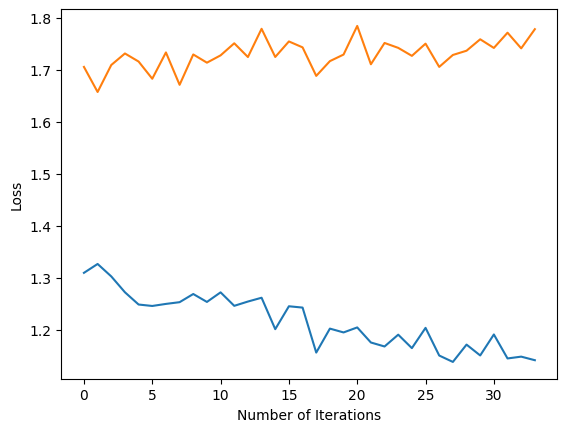

In [9]:
model = Transformer(vocab_size, x, config_block, device)
try:
    model.load_state_dict(torch.load('/kaggle/working/model'))
    print("model loaded")
except:
    print("not the same model")

m = model.to(device)
m.train()


def train(m):
    learning_rate = 3e-4
    optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 300, eta_min=1e-5)


    loss_list_t = []
    loss_list_v = []
    max_iters_total = 80000
    max_iters = int(max_iters_total/batch_size)
    eval_interval = 100

    idx = 0
    chunk_size = 25

    for iter in tqdm(range(max_iters)):

        # every once in a while evaluate the loss on train and val sets

        if iter % eval_interval == 0:
            torch.save(m.state_dict(), '/kaggle/working/model')

            print(optimizer.param_groups[0]["lr"])
            losses = estimate_loss(m, eval_iters, block_size, batch_size)
            loss_list_t.append(losses['train'].cpu())
            loss_list_v.append(losses['val'].cpu())
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        if iter % chunk_size == 0:
            m.xlstm.init_states(x)
            idx = random.randint(0, 1000000)

        # sample a batch of data
        #xb, yb = get_batch_xlstm('train', block_size, batch_size, idx)
        xb, yb = get_batch('train', block_size, batch_size)
        idx += 1

        # evaluate the loss
        start = time.time()
        logits, loss = m(xb, yb)
        end = time.time()
        #print("exe time : ", (end-start)/batch_size)

        torch.nn.utils.clip_grad_norm_(m.parameters(), max_norm=0.5)

        #scheduler.step()
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


    torch.save(m.state_dict(), '/kaggle/working/model')
    # draw loss
    print(loss)
    plt.plot(range(len(loss_list_t)), loss_list_t)
    plt.plot(range(len(loss_list_v)), loss_list_v)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()

train(m)


In [10]:
model = Transformer(vocab_size, x, config_block, device)
model.load_state_dict(torch.load('/kaggle/working/model'))
model = model.to(device)

context = torch.zeros((1, 1), dtype=torch.long, device=device)
#context = torch.tensor(encode(""), dtype=torch.long, device=device)
#context = context.view(1, context.shape[0])

for _ in range(500):
    context, out = model.generate(context, max_new_tokens=1)
    print(decode(out[0].tolist()), end="")


Ourry cowardom leave my daubt. Stide,
Shake thee arm
Halpier of withatly. But what part's with wo
rave reportself torlight: the He showes to them
I'll finectefce my truth,
That kin oursed by tone weake, sir, adval: chase. Go, blassan, got hereoms. Becaust.--
Sarth allour lorthess obellave tumple to coow;
Away, bried enturend Exerlar wif tray--
With, from whis, livial pless'd himbly fet.

KATHAlfied? Richmeremys k'te Mont thuncizaus
For en arites times if I have beat
No withough by him:
Some of w